# Loading data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation 
from pyts.image import MarkovTransitionField
import dask.dataframe as dd  
import pandas as pd


from scipy import signal as sign
from PIL import Image
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import matthews_corrcoef

import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

root_dir = "/home/polivares/scratch/Datasets/PowerLineFaults/"

X_train = np.load(root_dir + "dataset_spectrogram/train/images_train.npy")
y_train = np.load(root_dir + "dataset_spectrogram/train/labels_train.npy")
X_test = np.load(root_dir + "dataset_spectrogram/test/images_test.npy")
y_test = np.load(root_dir + "dataset_spectrogram/test/labels_test.npy")
X_val = np.load(root_dir + "dataset_spectrogram/val/images_val.npy")
y_val = np.load(root_dir + "dataset_spectrogram/val/labels_val.npy")

2022-10-07 14:08:31.594176: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-07 14:08:33.599081: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-07 14:08:36.860302: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-07 14:08:36.860597: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

# CNN-model

In [3]:
# Creación de modelo
model = models.Sequential()
# Capas encargadas de obtener información de la imagen
model.add(layers.Conv2D(256, (3, 3), activation='relu', input_shape=(256,256,1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# Capas para la clasificación en base a la información obtenida en 
# capas anteriores
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))
model.summary()

2022-10-07 14:08:49.883971: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-07 14:08:53.162394: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9357 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:02:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 256)     2560      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 256)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 128)     295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        73792     
                                                                 
 flatten (Flatten)           (None, 230400)            0

In [4]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience = 7)

checkpoint_path='CNN-model_spectrogram.ckpt'
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model.compile(loss = 'bce', optimizer = 'adam', metrics=['accuracy', tf.keras.metrics.Recall()])
history_cnn = model.fit(X_train, y_train, epochs=100, 
                        validation_data=(X_val, y_val),
                        batch_size=10,
                        callbacks=[early_stopping, cp_callback])

Epoch 1/100


2022-10-07 14:09:01.313667: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204


488/488 [==============================] - ETA: 0s - loss: 0.5828 - accuracy: 0.9362 - recall: 0.0034
Epoch 1: saving model to CNN-model_spectrogram.ckpt
488/488 [==============================] - 30s 46ms/step - loss: 0.5828 - accuracy: 0.9362 - recall: 0.0034 - val_loss: 0.1845 - val_accuracy: 0.9402 - val_recall: 0.0000e+00
Epoch 2/100
487/488 [============================>.] - ETA: 0s - loss: 0.1672 - accuracy: 0.9396 - recall: 0.0000e+00
Epoch 2: saving model to CNN-model_spectrogram.ckpt
488/488 [==============================] - 22s 45ms/step - loss: 0.1669 - accuracy: 0.9397 - recall: 0.0000e+00 - val_loss: 0.1562 - val_accuracy: 0.9402 - val_recall: 0.0000e+00
Epoch 3/100
487/488 [============================>.] - ETA: 0s - loss: 0.1310 - accuracy: 0.9398 - recall: 0.0000e+00
Epoch 3: saving model to CNN-model_spectrogram.ckpt
488/488 [==============================] - 22s 44ms/step - loss: 0.1312 - accuracy: 0.9397 - recall: 0.0000e+00 - val_loss: 0.1541 - val_accuracy: 0.940

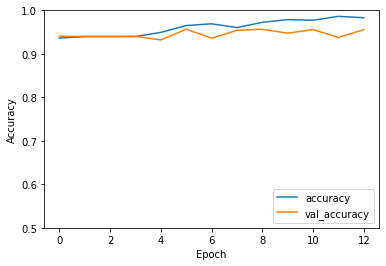

In [5]:
plt.plot(history_cnn.history['accuracy'], label='accuracy')
plt.plot(history_cnn.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

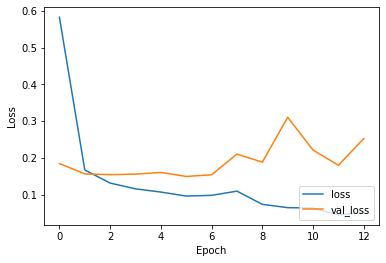

In [6]:
plt.plot(history_cnn.history['loss'], label='loss')
plt.plot(history_cnn.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [7]:
val_loss, val_acc, val_recall = model.evaluate(X_val,  y_val, verbose=2, batch_size=4)

305/305 - 3s - loss: 0.2525 - accuracy: 0.9557 - recall: 0.4795 - 3s/epoch - 9ms/step


In [8]:
val_predictions = (model.predict(X_val, batch_size=4)>0.5).reshape(1,-1)[0].astype(int)
val_real_values = y_val.T[0]

305/305 [==============================] - 2s 5ms/step


In [9]:
matthews_corrcoef(val_real_values, val_predictions)

0.5516618181761928

In [10]:
test_loss, test_acc, test_recall = model.evaluate(X_test,  y_test, verbose=2, batch_size=4)

654/654 - 5s - loss: 0.2721 - accuracy: 0.9461 - recall: 0.4684 - 5s/epoch - 7ms/step


In [11]:
test_predictions = (model.predict(X_test, batch_size=4)>0.5).reshape(1,-1)[0].astype(int)
test_real_values = y_test.T[0]

654/654 [==============================] - 4s 5ms/step


In [12]:
matthews_corrcoef(test_real_values, test_predictions)

0.48620694117273044

# Resnet-model

In [13]:
# Transfer Learning
base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(1, activation="sigmoid")(avg)

model = tf.keras.Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False # Esto impide que las capas se re entrenen

In [14]:
X_train_rgb = np.repeat(X_train, 3, -1)
X_val_rgb = np.repeat(X_val, 3, -1)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience = 7)

checkpoint_path='Resnet50-model_spectrogram.ckpt'
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model.compile(loss = 'bce', optimizer = 'adam', metrics=['accuracy', tf.keras.metrics.Recall()])
history_resnet = model.fit(X_train_rgb, y_train, epochs=100, 
                        validation_data=(X_val_rgb, y_val),
                        batch_size=10,
                        callbacks=[early_stopping, cp_callback])

2022-10-07 15:38:53.173262: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3836215296 exceeds 10% of free system memory.
2022-10-07 15:38:56.473773: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3836215296 exceeds 10% of free system memory.


Epoch 1/100
488/488 [==============================] - ETA: 0s - loss: 0.1643 - accuracy: 0.9420 - recall_1: 0.1973
Epoch 1: saving model to Resnet50-model_spectrogram.ckpt
488/488 [==============================] - 24s 42ms/step - loss: 0.1643 - accuracy: 0.9420 - recall_1: 0.1973 - val_loss: 0.1348 - val_accuracy: 0.9484 - val_recall_1: 0.4932
Epoch 2/100
488/488 [==============================] - ETA: 0s - loss: 0.1287 - accuracy: 0.9512 - recall_1: 0.3537
Epoch 2: saving model to Resnet50-model_spectrogram.ckpt
488/488 [==============================] - 18s 37ms/step - loss: 0.1287 - accuracy: 0.9512 - recall_1: 0.3537 - val_loss: 0.1487 - val_accuracy: 0.9500 - val_recall_1: 0.1918
Epoch 3/100
488/488 [==============================] - ETA: 0s - loss: 0.1135 - accuracy: 0.9567 - recall_1: 0.4490
Epoch 3: saving model to Resnet50-model_spectrogram.ckpt
488/488 [==============================] - 18s 37ms/step - loss: 0.1135 - accuracy: 0.9567 - recall_1: 0.4490 - val_loss: 0.1513 - 

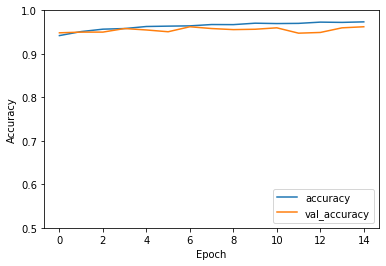

In [16]:
plt.plot(history_resnet.history['accuracy'], label='accuracy')
plt.plot(history_resnet.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

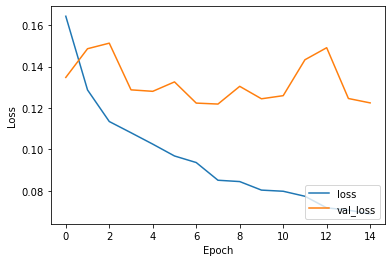

In [17]:
plt.plot(history_resnet.history['loss'], label='loss')
plt.plot(history_resnet.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [18]:
val_loss, val_acc, val_recall = model.evaluate(X_val_rgb,  y_val, verbose=2, batch_size=4)

305/305 - 8s - loss: 0.1225 - accuracy: 0.9623 - recall_1: 0.5205 - 8s/epoch - 27ms/step


In [19]:
val_predictions = (model.predict(X_val_rgb, batch_size=4)>0.5).reshape(1,-1)[0].astype(int)
val_real_values = y_val.T[0]

305/305 [==============================] - 8s 23ms/step


In [20]:
matthews_corrcoef(val_real_values, val_predictions)

0.6172365114872443

In [22]:
X_test_rgb = np.repeat(X_test, 3, -1)
test_loss, test_acc, test_recall = model.evaluate(X_test_rgb,  y_test, verbose=2, batch_size=4)

654/654 - 15s - loss: 0.1308 - accuracy: 0.9468 - recall_1: 0.4304 - 15s/epoch - 24ms/step


In [23]:
test_predictions = (model.predict(X_test_rgb, batch_size=4)>0.5).reshape(1,-1)[0].astype(int)
test_real_values = y_test.T[0]

654/654 [==============================] - 16s 23ms/step


In [24]:
matthews_corrcoef(test_real_values, test_predictions)

0.4730185212213657